# Simulate place cell responses to a rat running through a box

In [1]:
%matplotlib inline
from IPython import display
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import os

from anim import build_frames, create_mp4, merge_frames
from aux import save_time_file
from ntwk import LIFNtwk
import plot
from traj import RandomTraj, InferredTraj, upstream_spks_from_traj

import PARAMETERS as P

# GENERAL PARAMS
SAVE_DIR = 'sims/place'
BOX = (P.BOX_L, P.BOX_R, P.BOX_B, P.BOX_T)
DUR = 15

ASPECT = (P.BOX_T - P.BOX_B) / (P.BOX_R - P.BOX_L)
FIG_SIZE = np.array([10, 10*ASPECT])

# TRAJ PARAMS
SEED = 2

XY_0 = (P.BOX_L, P.BOX_T)
V_0 = (.141, -.141)

# NTWK PARAMS
N = 300
SYNS = ['AMPA']

NTWK_KWARGS = {
    't_m': P.T_M,  # (s)
    'e_leak': P.E_LEAK,  # (V)
    'v_th': P.V_TH,  # (V)
    'v_reset': P.V_RESET,  # (V)
    't_r': P.T_R,  # (s)
    'es_rev': {'AMPA': P.E_AMPA},  # (V)
    'ts_syn': {'AMPA': P.T_AMPA},  # (s)
    'ws_rcr': {'AMPA': np.zeros((N, N))},  # (unitless)
    'ws_up': {
        'AMPA': P.W_A_PL_CA3 * np.eye(N),
    },
}

### Generate a random trajectory and upstream spike trains

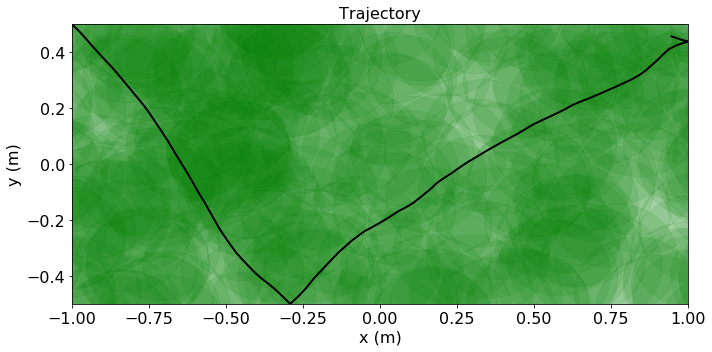

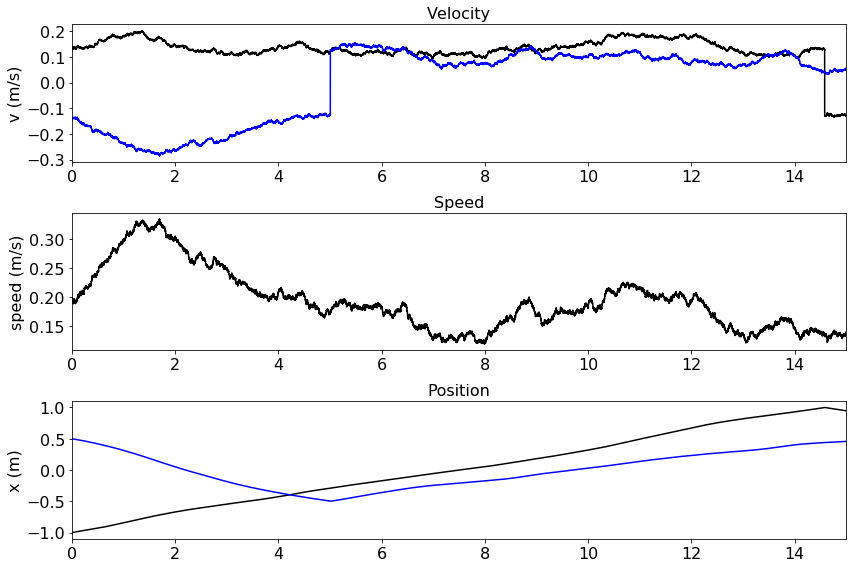

In [2]:
np.random.seed(SEED)

ts = np.arange(int(DUR/P.DT)) * P.DT

traj = RandomTraj(ts, P.S_TRAJ, 100, XY_0, V_0, BOX)

# place field ranges
pf_lb = [P.BOX_L - 0.1 * (P.BOX_R - P.BOX_L), P.BOX_B - 0.1 * (P.BOX_T - P.BOX_B)]
pf_ub = [P.BOX_R + 0.1 * (P.BOX_R - P.BOX_L), P.BOX_T + 0.1 * (P.BOX_T - P.BOX_B)]
centers = np.random.uniform(pf_lb, pf_ub, (N, 2)).T

stds = P.L_PL * np.ones(centers.shape[1])
max_rates = P.R_MAX_PL * np.ones(centers.shape[1])

spks_up = upstream_spks_from_traj(ts, traj.xys, centers, stds, max_rates)

time_file = save_time_file(os.path.join(SAVE_DIR, 'time.npy'), ts)
traj_file = traj.save(os.path.join(SAVE_DIR, 'traj.npy'))

# plot trajectory and place fields
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE, tight_layout=True)

# trajectory
ax.plot(*traj.xys.T, lw=2, color='k')

# place fields
for center, std in zip(centers.T, stds):
    ell = Ellipse(center, width=2*std, height=2*std, angle=0, color='g', alpha=0.1)
    ax.add_artist(ell)
    
ax.set_xlim(BOX[:2])
ax.set_ylim(BOX[2:])
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Trajectory')

plot.set_font_size(ax, 16)

fig, axs = plt.subplots(3, 1, figsize=(12, 8), tight_layout=True)

# velocity time-series
axs[0].plot(ts, traj.vs[:, 0], c='k')
axs[0].plot(ts, traj.vs[:, 1], c='b')
axs[0].set_xlim(ts[0], ts[-1])
axs[0].set_ylabel('v (m/s)')
axs[0].set_title('Velocity')

# speed time-series
speed = np.sqrt(traj.vs[:, 0]**2 + traj.vs[:, 1]**2)
axs[1].plot(ts, speed, c='k')
axs[1].set_xlim(ts[0], ts[-1])
axs[1].set_ylabel('speed (m/s)')
axs[1].set_title('Speed')

# position time-series
axs[2].plot(ts, traj.xys[:, 0], c='k')
axs[2].plot(ts, traj.xys[:, 1], c='b')
axs[2].set_xlim(ts[0], ts[-1])
axs[2].set_ylabel('x (m)')
axs[2].set_title('Position')

for ax in axs:
    plot.set_font_size(ax, 16)

### Compute network response

In [3]:
ntwk = LIFNtwk(**NTWK_KWARGS)
vs_init = P.E_LEAK * np.ones(N)
gs_init = {syn: np.zeros(N) for syn in SYNS}
ntwk_response = ntwk.run(spks_up, vs_init, gs_init, P.DT)
ntwk_response.place_field_centers = centers

ntwk_file = ntwk_response.save(os.path.join(SAVE_DIR, 'ntwk.npy'))

### Show trajectory and raster response

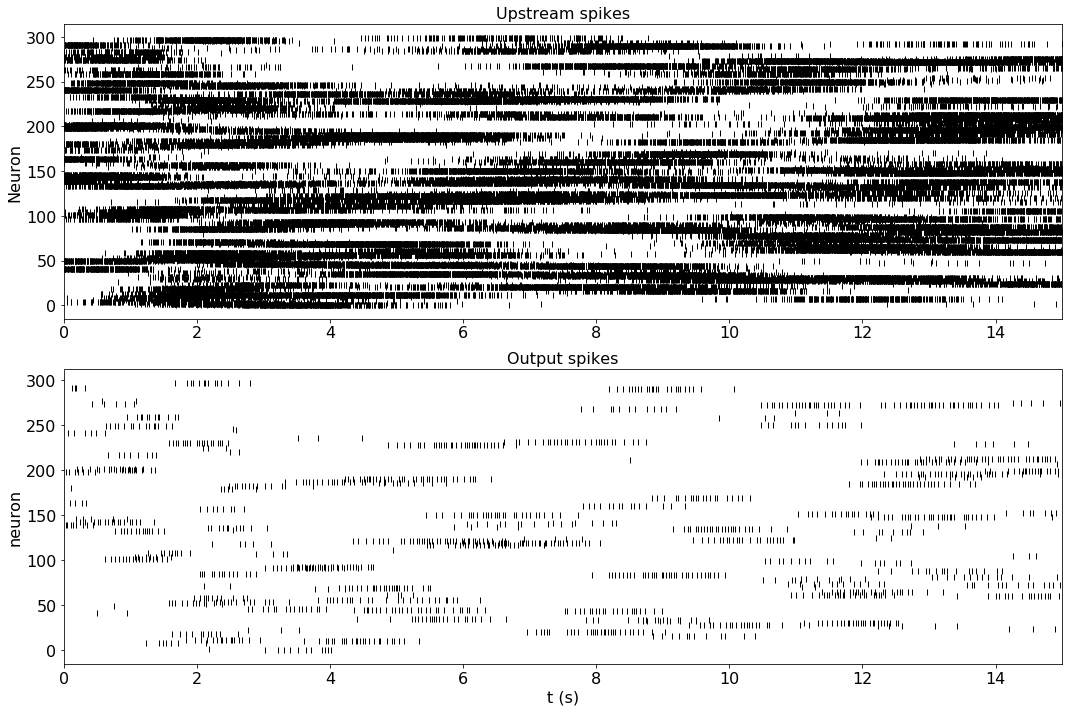

In [4]:
gs = gridspec.GridSpec(2, 1)
fig = plt.figure(figsize=(15, 10), tight_layout=True)

axs = [
    fig.add_subplot(gs[0, :]),
    fig.add_subplot(gs[1, :]),
]

# raster plot of place-sensitive cell responses
spk_times_up = spks_up.nonzero()[0] * P.DT

axs[0].scatter(spk_times_up, spks_up.nonzero()[1], marker='|', lw=1, c='k')
axs[0].set_xlim(ts[0], ts[-1])
axs[0].set_ylabel('Neuron')
axs[0].set_title('Upstream spikes')

plot.raster(
    axs[1],
    time_file,
    ntwk_file)

axs[1].set_xlim(ts[0], ts[-1])
axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('neuron')
axs[1].set_title('Output spikes')

for ax in axs:
    plot.set_font_size(ax, 16)

### Calculate, plot, and save inferred trajectory

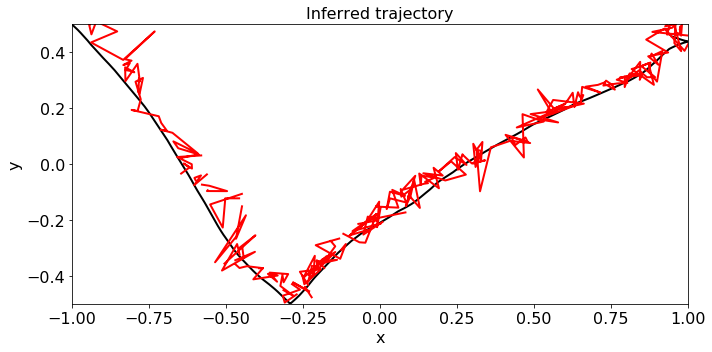

In [5]:
inferred = InferredTraj(
    ntwk_file=ntwk_file,
    time_file=time_file,
    window=0.05)

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE, tight_layout=True)
ax.plot(*traj.xys.T, color='k', lw=2)
ax.plot(*inferred.xys.T, color='r', lw=2)

ax.set_xlim(BOX[:2])
ax.set_ylim(BOX[2:])

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_title('Inferred trajectory')

plot.set_font_size(ax, 16)

inferred_file = inferred.save(os.path.join(SAVE_DIR, 'inferred.npy'))

### Animate trajectory and neural response

In [6]:
frames_traj = build_frames.traj(
    save_prefix=os.path.join(SAVE_DIR, 'traj/frame'),
    time_file=time_file,
    traj_file=traj_file,
    box=BOX,
    fps=60,
    title='Trajectory',
    x_label='x (m)',
    y_label='y (m)',
    fig_size=.7*FIG_SIZE,
    verbose=True)

frames_ntwk = build_frames.ntwk_activity(
    save_prefix=os.path.join(SAVE_DIR, 'ntwk/frame'),
    time_file=time_file,
    ntwk_file=ntwk_file,
    box=BOX,
    fps=60,
    spk_size=500,
    frames_per_spk=2,
    title='Network activity',
    x_label='x (m)',
    y_label='y (m)',
    fig_size=.7*FIG_SIZE)

frames_inferred = build_frames.traj(
    save_prefix=os.path.join(SAVE_DIR, 'inferred/frame'),
    time_file=time_file,
    traj_file=inferred_file,
    box=BOX,
    fps=60,
    location_size=200,
    location_color=(0, 0, 1),
    cov_cutoff=np.inf,
    title='Inferred trajectory',
    x_label='x (m)',
    y_label='y (m)',
    fig_size=.7*FIG_SIZE,
    verbose=True)

### Merge trajectory and network frames

In [7]:
save_prefix = os.path.join(SAVE_DIR, 'merged/frame')
rects = [(0, 0, 1, 1), (1, 0, 2, 1), (0, 1, 1, 2)]
size = (2, 2)

frames_merged = merge_frames(
    [frames_traj, frames_ntwk, frames_inferred], save_prefix, rects, size)

### Make movie of trajectory, network activity, and inferred trajectory

In [8]:
movie = create_mp4(
    frames_merged, os.path.join(SAVE_DIR, 'full'), playback_fps=30, verbose=True)

Loading source images...


Source images loaded.
Generating movie and saving at "sims/place/full.mp4"...
Movie generated.
